<a href="https://colab.research.google.com/github/Adhyatik/MLM-PROJECT-REPORT/blob/main/Group6_FAAD_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment on Fraud Analytics and Anomaly Detection**

In [1]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Step 1: Install the required library
!pip install gdown

In [4]:
# Step 3: Read the CSV file into a DataFrame
import pandas as pd
df = pd.read_csv('/content/UNSW_NB15_traintest_backdoor.csv')
# Step 4: Display a sample of the DataFrame
print(df.sample(5))

            dur  proto=udp  proto=arp  proto=tcp  proto=igmp  proto=ospf  \
40921  0.000301          0          0          1           0           0   
3092   0.000020          1          0          0           0           0   
17511  0.018968          0          0          1           0           0   
49897  0.011854          0          0          1           0           0   
20270  0.010153          0          0          1           0           0   

       proto=sctp  proto=gre  proto=ggp  proto=ip  ...  ct_src_dport_ltm  \
40921           0          0          0         0  ...          0.066666   
3092            0          0          0         0  ...          0.044445   
17511           0          0          0         0  ...          0.000000   
49897           0          0          0         0  ...          0.022222   
20270           0          0          0         0  ...          0.022222   

       ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
40921          0.

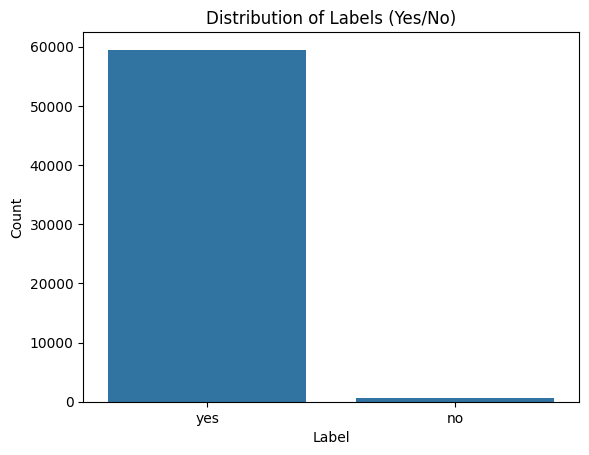

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'class' is the last column name (if not, replace with the actual name)
# Re-read the original dataframe to avoid issues from previous cell execution
df = pd.read_csv('/content/UNSW_NB15_traintest_backdoor.csv')
class_column_name = df.columns[-1]

# Fill missing values in 'class' column with the mode (most frequent value)
# Check if the column has any values before calculating the mode
if not df[class_column_name].empty:
    df[class_column_name] = df[class_column_name].fillna(df[class_column_name].mode()[0])

# Create a new column 'attack_cat' with 'yes' and 'no' based on 'class'
df['attack_cat'] = df[class_column_name].map({0: 'yes', 1: 'no'})

# Drop rows with values other than 0 and 1 in the 'class' column
df = df[df[class_column_name].isin([0, 1])]

# Create a new figure before plotting
plt.figure()
sns.countplot(x='attack_cat', data=df)
plt.title('Distribution of Labels (Yes/No)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

**COUNT OF MISSING VALUES**

In [25]:
missing_values = df.isnull().sum()
print(missing_values)
missing_percentage = (missing_values / len(df)) * 100
missing_percentage

dur                0
proto=udp          0
proto=arp          0
proto=tcp          0
proto=igmp         0
                  ..
ct_src_ltm         0
ct_srv_dst         0
is_sm_ips_ports    1
class              0
attack_cat         0
Length: 198, dtype: int64


,0
dur,0.000000
proto=udp,0.000000
proto=arp,0.000000
proto=tcp,0.000000
proto=igmp,0.000000
...,...
ct_src_ltm,0.000000
ct_srv_dst,0.000000
is_sm_ips_ports,0.001665
class,0.000000


In [26]:
df.shape

(60070, 198)

**## Feature selection: Top 10 Features are selected on the basis of the random Forest**

In [27]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Assuming 'df' is your DataFrame and has both features and target columns.
# If your target column is named 'class', separate it from features
X = df.drop(columns=['attack_cat'])  # Drop target column
y = df['attack_cat']  # Target column
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
# Sort the features by importance
feature_names = X.columns
important_features = pd.Series(importances, index=feature_names).sort_values(ascending=False)
important_features

,0
class,0.331005
ct_dst_sport_ltm,0.118197
proto=unas,0.075853
proto=udp,0.059496
sbytes,0.059247
...,...
proto=ddp,0.000000
proto=sccopmce,0.000000
state=ACC,0.000000
proto=crtp,0.000000


In [28]:
# Get the top 10 feature names
top_10_features = important_features.head(10).index.tolist()

# Print the names
top_10_features

['class',
 'ct_dst_sport_ltm',
 'proto=unas',
 'proto=udp',
 'sbytes',
 'smean',
 'ct_srv_dst',
 'sload',
 'ct_srv_src',
 'ct_src_dport_ltm']

In [29]:
# Select top N features (for example, top 10)
selected_features = important_features.head(10).index
print("Selected Features:", selected_features)

Selected Features: Index(['class', 'ct_dst_sport_ltm', 'proto=unas', 'proto=udp', 'sbytes',
       'smean', 'ct_srv_dst', 'sload', 'ct_srv_src', 'ct_src_dport_ltm'],
      dtype='object')


The Selected Features are:-"'class',
 'ct_dst_sport_ltm',
 'proto=unas',
 'proto=udp',
 'sbytes',
 'smean',
 'ct_srv_dst',
 'sload',
 'ct_srv_src',
 'ct_src_dport_ltm'"

In [30]:
# X_selected = X[selected_features]

X_selected = X[selected_features]

**# SMOTE Sampling**

In [32]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE on the entire dataset before splitting
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_selected, y)

# Check the class distribution after SMOTE
print("SMOTE Class Distribution:\n", pd.Series(y_smote).value_counts())

# Print a sample of the resampled dataset
smote_sample = pd.concat([X_smote, y_smote], axis=1)
print("\nSMOTE Resampled Dataset Sample:\n", smote_sample.head())

SMOTE Class Distribution:
 attack_cat
yes    59487
no     59487
Name: count, dtype: int64

SMOTE Resampled Dataset Sample:
    class  ct_dst_sport_ltm  proto=unas  proto=udp    sbytes     smean  \
0    0.0               0.0           0          1  0.001397  0.149456   
1    0.0               0.0           0          1  0.005123  0.579484   
2    0.0               0.0           0          1  0.003091  0.343750   
3    0.0               0.0           0          1  0.002583  0.286685   
4    0.0               0.0           0          1  0.006181  0.703125   

   ct_srv_dst     sload  ct_srv_src  ct_src_dport_ltm attack_cat  
0    0.016393  0.033751    0.016129          0.000000        yes  
1    0.016393  0.164858    0.016129          0.000000        yes  
2    0.032787  0.159880    0.032258          0.000000        yes  
3    0.032787  0.112275    0.032258          0.022222        yes  
4    0.032787  0.159131    0.032258          0.022222        yes  


**DOWNSAMPLING**

In [33]:
from imblearn.under_sampling import RandomUnderSampler

# Apply downsampling on the entire dataset before splitting
down_sampler = RandomUnderSampler(random_state=42)
X_down, y_down = down_sampler.fit_resample(X_selected, y)

# Check the class distribution after downsampling
print("Downsampled Class Distribution:\n", pd.Series(y_down).value_counts())

# Print a sample of the resampled dataset
down_sample = pd.concat([X_down, y_down], axis=1)
print("\nDownsampled Resampled Dataset Sample:\n", down_sample.head())

Downsampled Class Distribution:
 attack_cat
no     583
yes    583
Name: count, dtype: int64

Downsampled Resampled Dataset Sample:
      class  ct_dst_sport_ltm  proto=unas  proto=udp    sbytes     smean  \
243    1.0          0.000000           0          0  0.003683  0.024456   
244    1.0          0.200000           0          0  0.000508  0.048912   
245    1.0          0.000000           0          0  0.003006  0.016304   
246    1.0          0.022222           0          0  0.000508  0.048912   
247    1.0          0.000000           0          0  0.001270  0.011548   

     ct_srv_dst     sload  ct_srv_src  ct_src_dport_ltm attack_cat  
243    0.000000  0.000002    0.000000          0.000000         no  
244    0.147541  0.049901    0.145161          0.199999         no  
245    0.000000  0.000003    0.000000          0.000000         no  
246    0.032787  0.016634    0.032258          0.022222         no  
247    0.000000  0.000002    0.000000          0.000000         no  


**UPSAMPLING**

In [34]:
from imblearn.over_sampling import RandomOverSampler
# Apply upsampling on the entire dataset before splitting
up_sampler = RandomOverSampler(random_state=42)
X_up, y_up = up_sampler.fit_resample(X_selected, y)
# Check the class distribution after upsampling
print("Upsampled Class Distribution:", pd.Series(y_up).value_counts())
# Print a sample of the resampled dataset
up_sample = pd.concat([X_up, y_up], axis=1)
print("Upsampled Resampled Dataset Sample:\n", up_sample.head())

Upsampled Class Distribution: attack_cat
yes    59487
no     59487
Name: count, dtype: int64
Upsampled Resampled Dataset Sample:
    class  ct_dst_sport_ltm  proto=unas  proto=udp    sbytes     smean  \
0    0.0               0.0           0          1  0.001397  0.149456   
1    0.0               0.0           0          1  0.005123  0.579484   
2    0.0               0.0           0          1  0.003091  0.343750   
3    0.0               0.0           0          1  0.002583  0.286685   
4    0.0               0.0           0          1  0.006181  0.703125   

   ct_srv_dst     sload  ct_srv_src  ct_src_dport_ltm attack_cat  
0    0.016393  0.033751    0.016129          0.000000        yes  
1    0.016393  0.164858    0.016129          0.000000        yes  
2    0.032787  0.159880    0.032258          0.000000        yes  
3    0.032787  0.112275    0.032258          0.022222        yes  
4    0.032787  0.159131    0.032258          0.022222        yes  


**ISOLATION FOREST**

In [35]:
from sklearn.ensemble import IsolationForest

anomaly_inputs = ['ct_dst_sport_ltm', 'proto=unas', 'proto=udp', 'sbytes', 'smean', 'ct_srv_dst', 'sload', 'ct_srv_src', 'ct_src_dport_ltm', 'class']

model_IF = IsolationForest(contamination=0.1, random_state=42)

# **Isolation Forest applied on Original Datset**

In [38]:
model_IF.fit(df[anomaly_inputs])
df['anomaly_scores'] = model_IF.decision_function(df[anomaly_inputs])
df['anomaly'] = model_IF.predict(df[anomaly_inputs])
df.loc[:, ['ct_dst_sport_ltm', 'proto=unas', 'proto=udp', 'sbytes', 'smean', 'ct_srv_dst', 'sload', 'ct_srv_src', 'ct_src_dport_ltm', 'class', 'anomaly_scores', 'anomaly']]

,ct_dst_sport_ltm,proto=unas,proto=udp,sbytes,smean,ct_srv_dst,sload,ct_srv_src,ct_src_dport_ltm,class,anomaly_scores,anomaly
0,0.0,0,1,0.001397,0.149456,0.016393,0.033751,0.016129,0.000000,0.0,0.008948,1
1,0.0,0,1,0.005123,0.579484,0.016393,0.164858,0.016129,0.000000,0.0,-0.128873,-1
2,0.0,0,1,0.003091,0.343750,0.032787,0.159880,0.032258,0.000000,0.0,-0.077199,-1
3,0.0,0,1,0.002583,0.286685,0.032787,0.112275,0.032258,0.022222,0.0,-0.074062,-1
4,0.0,0,1,0.006181,0.703125,0.032787,0.159131,0.032258,0.022222,0.0,-0.154696,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
60065,0.0,0,0,0.026249,0.414402,0.032787,0.000056,0.032258,0.000000,0.0,0.062426,1
60066,0.0,0,0,0.008594,0.019022,0.000000,0.000006,0.000000,0.000000,0.0,0.135306,1
60067,0.0,0,0,0.012447,0.021060,0.032787,0.000202,0.064516,0.000000,0.0,0.148019,1
60068,0.0,0,0,0.005970,0.044158,0.180328,0.000527,0.112903,0.022222,0.0,0.121723,1


Outlier Method: Isolation Forest
Number of anomalous values: 6006
Number of non-anomalous values: 54064
Total number of values: 60070
Percentage of anomalous values: 10.00%


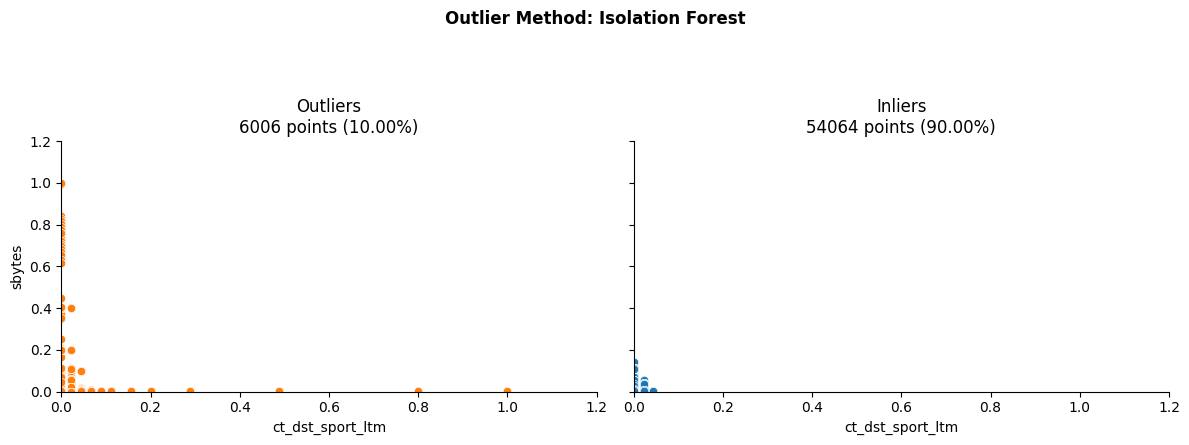

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt # This should be outside the function

def outlier_plot(data, outlier_method_name, x_var, y_var,
                 xaxis_limits=[0,1], yaxis_limits=[0,1]):
    print(f'Outlier Method: {outlier_method_name}')
    # Compute anomaly counts
    num_anomalies = len(data[data['anomaly'] == -1])
    num_inliers = len(data[data['anomaly'] == 1])
    total_values = len(data)
    # Calculate anomaly percentage
    anomaly_percentage = (num_anomalies / total_values) * 100
    print(f"Number of anomalous values: {num_anomalies}")
    print(f"Number of non-anomalous values: {num_inliers}")
    print(f"Total number of values: {total_values}")
    print(f"Percentage of anomalous values: {anomaly_percentage:.2f}%")
    # Create FacetGrid plot
    g = sns.FacetGrid(data, col='anomaly', height=4, hue='anomaly', hue_order=[1, -1], aspect=1.5) # Added aspect for better visualization
    g.map(sns.scatterplot, x_var, y_var)
    # Customize plot title and axes
    g.fig.suptitle(f'Outlier Method: {outlier_method_name}', y=1.10, fontweight='bold')
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)  # Use provided limits if specified
    axes = g.axes.flatten()
    axes[0].set_title(f"Outliers\n{num_anomalies} points ({anomaly_percentage:.2f}%)")
    axes[1].set_title(f"Inliers\n{num_inliers} points ({100 - anomaly_percentage:.2f}%)")
    plt.tight_layout() # Improves spacing between subplots
    plt.show() # To display the plot
    return g

outlier_plot(df, 'Isolation Forest', 'ct_dst_sport_ltm', 'sbytes', [0, df['ct_dst_sport_ltm'].max() * 1.2], [0, df['sbytes'].max() * 1.2]); #Passing x and y limits for dynamic scaling

# **Isolation Forest on SMOTE**

Outlier Method: Isolation Forest
Number of anomalous values: 11898
Number of non-anomalous values: 107076
Total number of values: 118974
Percentage of anomalous values: 10.00%


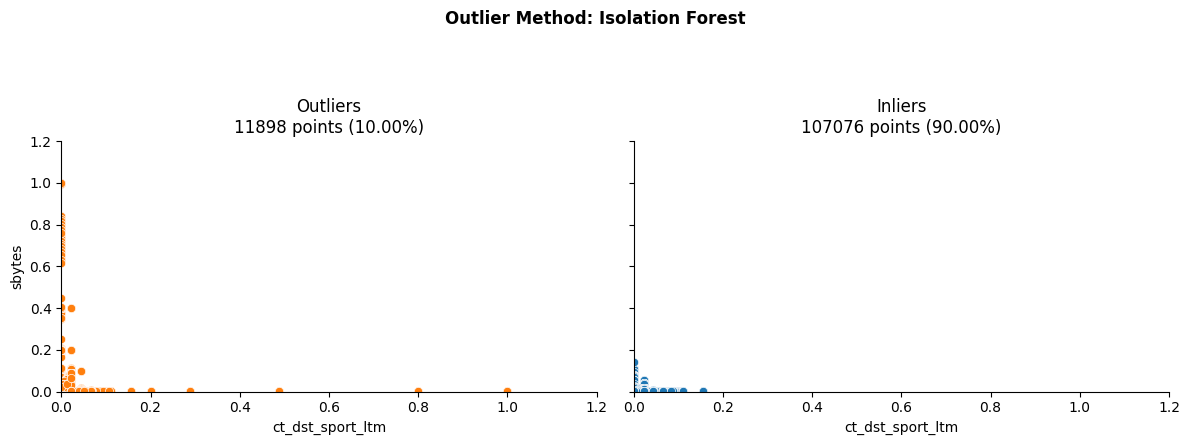

In [42]:
model_IF.fit(smote_sample[anomaly_inputs])
smote_sample['anomaly_scores'] = model_IF.decision_function(smote_sample[anomaly_inputs])
smote_sample['anomaly'] = model_IF.predict(smote_sample[anomaly_inputs])
outlier_plot(smote_sample, 'Isolation Forest', 'ct_dst_sport_ltm', 'sbytes', [0, smote_sample['ct_dst_sport_ltm'].max() * 1.2], [0, smote_sample['sbytes'].max() * 1.2]);

# **Isolation Forest on UPSAMPLE**

Outlier Method: Isolation Forest
Number of anomalous values: 11898
Number of non-anomalous values: 107076
Total number of values: 118974
Percentage of anomalous values: 10.00%


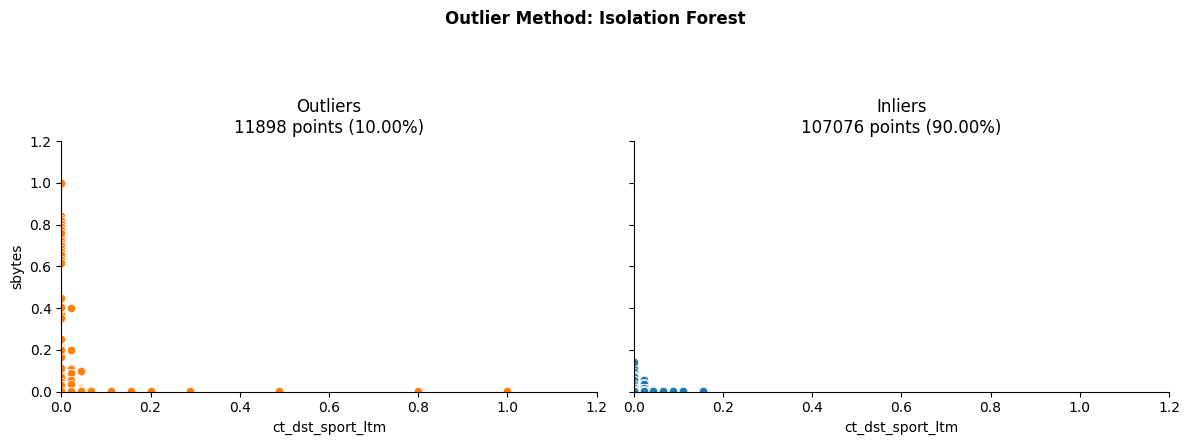

In [43]:
model_IF.fit(up_sample[anomaly_inputs])
up_sample['anomaly_scores'] = model_IF.decision_function(up_sample[anomaly_inputs])
up_sample['anomaly'] = model_IF.predict(up_sample[anomaly_inputs])
outlier_plot(up_sample, 'Isolation Forest', 'ct_dst_sport_ltm', 'sbytes', [0, up_sample['ct_dst_sport_ltm'].max() * 1.2], [0, up_sample['sbytes'].max() * 1.2]);



# **Isolation Forest on Downsample**

Outlier Method: Isolation Forest
Number of anomalous values: 117
Number of non-anomalous values: 1049
Total number of values: 1166
Percentage of anomalous values: 10.03%


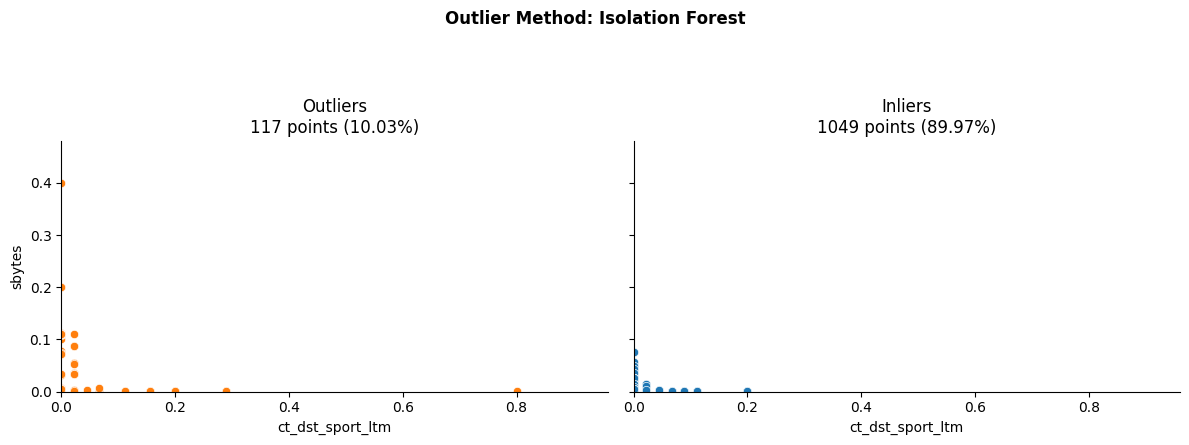

In [44]:
model_IF.fit(down_sample[anomaly_inputs])
down_sample['anomaly_scores'] = model_IF.decision_function(down_sample[anomaly_inputs])
down_sample['anomaly'] = model_IF.predict(down_sample[anomaly_inputs])
outlier_plot(down_sample, 'Isolation Forest', 'ct_dst_sport_ltm', 'sbytes', [0, down_sample['ct_dst_sport_ltm'].max() * 1.2], [0, down_sample['sbytes'].max() * 1.2]);

# **Splitting**

## **Splitting the SMOTE Dataset**

In [46]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.25, random_state=42, stratify=y_smote)

## **Splitting the Downsampled Dataset**


In [47]:
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X_down, y_down, test_size=0.25, random_state=42, stratify=y_down)

## **Splitting the Upsampled Dataset**


In [48]:
# Split the upsampled dataset
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_up, y_up, test_size=0.25, random_state=42)

**ANN**

In [50]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

# Assuming X_train_smote contains string columns, you need to convert them to numerical
# Replace 'string_column_name1', 'string_column_name2' etc. with the actual names
# of your string columns in X_train_smote
for column in X_train_smote.select_dtypes(include=['object']).columns:
    X_train_smote[column] = pd.factorize(X_train_smote[column])[0]

# Ensure y_train_smote is also numerical (0 and 1) if it's not already:
y_train_smote = pd.factorize(y_train_smote)[0]

model = keras.Sequential([
    keras.layers.Dense(26, input_shape=(X_train_smote.shape[1],), activation='relu'), # Adjusted input_shape
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_smote, y_train_smote, epochs=100)

Epoch 1/100
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9900 - loss: 0.1065
Epoch 2/100
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 1.8991e-05
Epoch 3/100
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 1.0000 - loss: 2.5922e-06
Epoch 4/100
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 1.0000 - loss: 4.6872e-07
Epoch 5/100
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 9.4094e-08
Epoch 6/100
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 2.1464e-08
Epoch 7/100
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 1.0000 - loss: 7.1952e-09
Epoch 8/100
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 4.1173e-09
Epoch 9/100
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 3.4801e-09
Epoch 10/100
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 1.0000 - loss: 3.2092e-09
Epoch 11/100
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.000

In [53]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

# ... (your existing code) ...

# Before evaluating the model, preprocess X_test_smote:
for column in X_test_smote.select_dtypes(include=['object']).columns:
    X_test_smote[column] = pd.factorize(X_test_smote[column])[0]

# Ensure y_test_smote is also numerical (0 and 1) if it's not already:
y_test_smote = pd.factorize(y_test_smote)[0] # Applying the same preprocessing for y_test_smote

# Now evaluate the model:
model.evaluate(X_test_smote, y_test_smote)

930/930 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 25.1143


[25.101255416870117, 0.0]

In [54]:
yp = model.predict(X_test_smote)
yp = (yp > 0.5).astype(int) # Convert probabilities to binary predictions
yp[:5]

930/930 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[1],
       [0],
       [1],
       [1],
       [1]])

In [55]:
y_pred_smote = yp.flatten().astype(int)

In [56]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test_smote, y_pred_smote))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00   14872.0
           1       0.00      0.00      0.00   14872.0

    accuracy                           0.00   29744.0
   macro avg       0.00      0.00      0.00   29744.0
weighted avg       0.00      0.00      0.00   29744.0



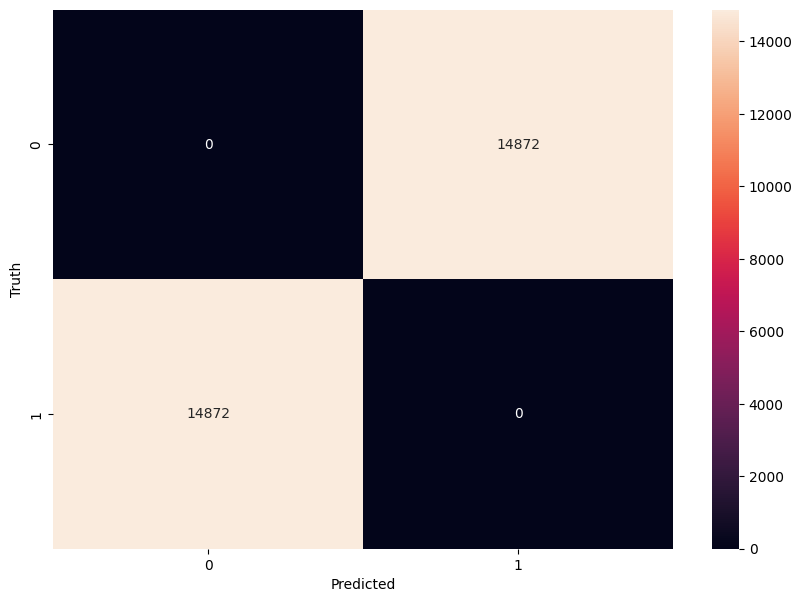

In [57]:
import seaborn as sns
cm = confusion_matrix(y_test_smote, y_pred_smote)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()